Training model 1/100
Training model 2/100
Training model 3/100
Training model 4/100
Training model 5/100
Training model 6/100
Training model 7/100
Training model 8/100
Training model 9/100
Training model 10/100
Training model 11/100
Training model 12/100
Training model 13/100
Training model 14/100
Training model 15/100
Training model 16/100
Training model 17/100
Training model 18/100
Training model 19/100
Training model 20/100
Training model 21/100
Training model 22/100
Training model 23/100
Training model 24/100
Training model 25/100
Training model 26/100
Training model 27/100
Training model 28/100
Training model 29/100
Training model 30/100
Training model 31/100
Training model 32/100
Training model 33/100
Training model 34/100
Training model 35/100
Training model 36/100
Training model 37/100
Training model 38/100
Training model 39/100
Training model 40/100
Training model 41/100
Training model 42/100
Training model 43/100
Training model 44/100
Training model 45/100
Training model 46/1

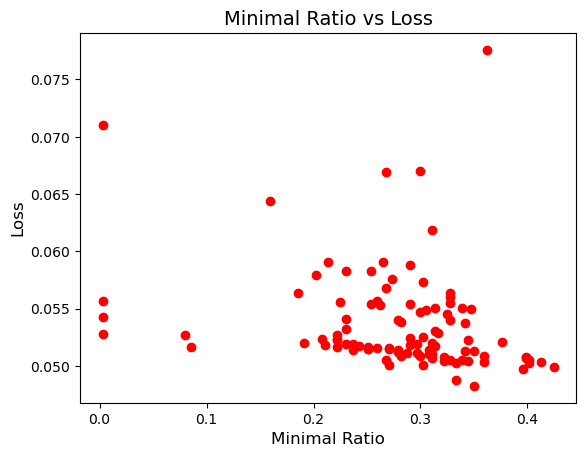

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Generate random data within the range (-10, 10)
input_data = 20 * torch.rand((1000, 1)) - 10
target_data = torch.cos(input_data)

# Function to calculate total number of trainable parameters
def get_param_count(model):
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

# Define a model with the same architecture as before, matching SimpleNet
class SimpleNet(nn.Module):
    def __init__(self, input_dim=1, hidden_layers=[5, 10, 10, 10, 5], output_dim=1):
        super(SimpleNet, self).__init__()
        layer_stack = []
        layer_stack.append(nn.Linear(input_dim, hidden_layers[0]))
        for i in range(len(hidden_layers) - 1):
            layer_stack.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
        layer_stack.append(nn.Linear(hidden_layers[-1], output_dim))
        self.layers = nn.ModuleList(layer_stack)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        return self.layers[-1](x)

# Compute the gradient norm (p=2 norm) for the model
def compute_grad_norm(model):
    norms = []
    for param in model.parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm(2).item()
            norms.append(grad_norm)
    return np.mean(norms)  

# Function to calculate the proportion of eigenvalues greater than zero (minimal ratio)
def eigen_minimal_ratio(hessian_matrix):
    eig_values, _ = np.linalg.eig(hessian_matrix)
    positive_eig_count = np.sum(eig_values > 0)
    return positive_eig_count / len(eig_values)

# Phase 1: Standard training with MSE loss
def initial_training(model, optimizer, loss_function, input_data, target_data, epochs=500):
    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(input_data)
        loss = loss_function(predictions, target_data)
        loss.backward()
        optimizer.step()

# Phase 2: Additional training to minimize gradient norm
def minimize_gradient_norm(model, optimizer, input_data, epochs=500):
    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(input_data)
        grad_norm = compute_grad_norm(model)
        grad_norm_tensor = torch.tensor(grad_norm, requires_grad=True)
        grad_norm_tensor.backward()  
        optimizer.step()

# Train the network and track the loss and minimal ratio for 100 times (trials)
def train_network(epochs=100, trials=100):
    minimal_ratios = []
    loss_history = []

    for trial in range(trials):
        print(f"Training model {trial + 1}/{trials}")

        # Reinitialize model, optimizer, and loss function
        model = SimpleNet()
        loss_function = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        cumulative_loss = 0
        for epoch in range(epochs):
            optimizer.zero_grad()
            predictions = model(input_data)
            loss = loss_function(predictions, target_data)
            loss.backward()
            optimizer.step()

            cumulative_loss += loss.item()

        loss_history.append(cumulative_loss / len(input_data))

        # Compute Hessian matrix
        param_count = get_param_count(model)
        hessian_matrix = torch.zeros((param_count, param_count))

        pred_output = model(input_data)
        squared_loss = ((pred_output - target_data) ** 2).mean()

        # Calculate Jacobian
        jacobian = torch.autograd.grad(squared_loss, list(model.parameters()), create_graph=True)
        jacobian_flattened = torch.cat([jacob.flatten() for jacob in jacobian])

        for idx in range(param_count):
            grad_result = torch.autograd.grad(jacobian_flattened[idx], list(model.parameters()), retain_graph=True)
            hessian_matrix[idx] = torch.cat([grad_val.flatten() for grad_val in grad_result])

        minimal_ratios.append(eigen_minimal_ratio(hessian_matrix.numpy()))

    return minimal_ratios, loss_history

# Train the network for 100 trials and gather results
min_ratios, final_losses = train_network(trials=100)

# Plot minimal ratio vs loss
plt.scatter(min_ratios, final_losses, c='red', marker='o')  
plt.xlabel("Minimal Ratio", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Minimal Ratio vs Loss", fontsize=14)

plt.show()
